Project 4: Generative Adversarial Networks
======
In this project, you are expected to fill in the missing parts of a PyTorch implementation of the Deep Convolutional Generative Adversarial Network (DCGAN) and test its performance on several datasets.

We will be using datasets with small images for this project, because high-resolution GANs take notoriously long to train.

**References:**

[1] [Radford, A., Metz, L. and Chintala, S., 2015. Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.](https://arxiv.org/abs/1511.06434)

[2] [MNIST dataset.](http://yann.lecun.com/exdb/mnist/)

[3] [FashionMNIST dataset.](https://github.com/zalandoresearch/fashion-mnist)


## Assignment 4A: DCGAN

### Verify your PyTorch installation

In [1]:
import torch
import torchvision

# Print Basic Information
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print("Torchvision", torchvision.__version__)
print('Device:', torch.device('cuda:0'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4 # The number of parallel processes used to read data
gpu_id = [0,1,2,3] # only modify if you machine has more than one GPU card
torch.cuda.device_count()

Torch 1.3.0 CUDA 10.1.243
Torchvision 0.4.1a0+d94043a
Device: cuda:0


4

In [2]:
#import statements
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from torchsummary import summary
import numpy as np

### 1) Load and prepare the dataset (5 points)

Pick either _MNIST_ or _FashionMNIST_ as your dataset for this assignment. Both datasets contain grayscale images with a natural resolution of $28\times28$ pixels, have 10 classes and can be imported from `torchvision.datasets`. 
The color channels _MNIST_ as well as in _FashionMNIST_ are stored inverted, ie with white content on a black background. This is because, per default, convolution layers in the network add zero-padding to the image, hence a black background works more naturally and yields better results during training.
We do, however, want to show our results with a white background. To that end, add appropriate functionality in the plotting/visualization functions throughout this notebook to invert and clamp the image values (see below visualization).

<img src="img/mnist_example.JPG" width="800">
<img src="img/fashion_mnist_example.JPG" width="800">


Implement the data loading, create the necessary data transforms such that your training images have $32\times32$ pixels, and have a value range between $[-1, 1]$:

Consider whether you can implement some data augmentation, and if possible, do so.

In [3]:
epochs = 20
batch_size = 128
learning_rate = 0.0002
workers = 4 # The number of parallel processes used to read data
gpu_id = [0,1,2,3] # only modify if you machine has more than one GPU card

In [5]:
#######################################################################################################
# TODO 1: Load dataset. Implement the necessary functions so your data has a resolution of 32x32 pixels
# and the values are normalized to a [-1, 1] range. 
# Consider whether you can implement some data augmentation, and if possible, do so.
#######################################################################################################
#train_dataset = None
train_dataset = datasets.MNIST(root='./minst',download=True,
                           transform=transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               ####Data Augmenttation
                               #transforms.RandomHorizontalFlip(),  
                               #transforms.RandomRotation(20),
                               #transforms.RandomVerticalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5],[0.5]),
                           ]))
# Create the dataloader
#dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
#                                         shuffle=True, num_workers=workers)

print("Dataset length: ", len(train_dataset))
print("Image size: {}".format(train_dataset[0][0].size()))
print("value range: [ {} - {} ]".format(torch.min(train_dataset[0][0]), torch.max(train_dataset[0][0])))

Dataset length:  60000
Image size: torch.Size([1, 32, 32])
value range: [ -1.0 - 0.9843137264251709 ]


#### Inspect the training data

Visualize a few examples from your training data.

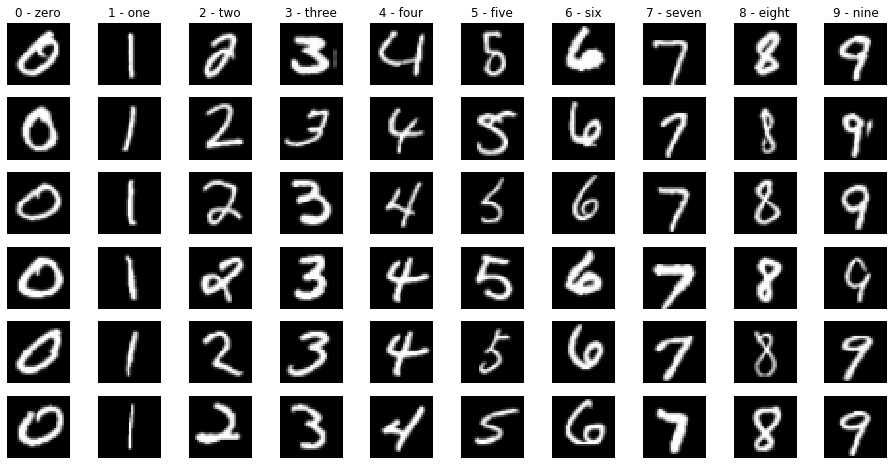

In [6]:
labels = train_dataset.classes
fig = plt.figure(figsize=(16, 8))
rows = 6

images = {}
for label in range(len(labels)):
    images[label] = []

#find some images for each label    
for x in range(1000):
    rand = np.random.randint(len(train_dataset))
    label = train_dataset[rand][1]
    if len(images[label]) > rows:
        continue
    images[label].append(train_dataset[rand][0][0,:,:])
    
for label in range(len(labels)):
    for row in range(rows):
        image = images[label][row]
        fig.add_subplot(rows, len(labels), row * len(labels) + label + 1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        if row == 0:
            plt.title(labels[label])
plt.show()

### 2) Choose appropriate hyperparameters for the training (4 points)

In [7]:
#######################################################################################################
# TODO 2: choose sensible training parameters for DCGAN training. 
# Start with few epochs while you design the network, and increase once you think you have a good setup.
# Since GANs train slowly, you may have to use at quite a few epochs to see good results.
#######################################################################################################
batch_size = 128
lr = 0.0002
num_epochs = 20

nz = 100 #length of latent vector
ngf = 128 #relates to the depth of feature maps carried through the generator
ndf = 128 # Size of feature maps in discriminator
nc = 1  #number of color channels in the input images.

            

### 3) Implement the generator network (8 points)
The expected output of this GAN should look like this (or better):

<img src="img/DCGAN_MNIST.png" align='left' width="355">
<img src="img/DCGAN_fashionMNIST.png" align='left' width="355">

Implement the DCGAN Generator and Discriminator networks for an output size of $32\times32$ pixels according to the given network diagrams. 

<img src="img/DCGAN_Generator.png" align='left' width="800">


Create a function to initialize the weights for `nn.Conv2d` and `nn.ConvTranspose2d` layers with a custom distribution. To that end, complete the function `normal_init`, which initialized the weights of the given pytorch layer with a Normal distribution centered around $mean$ and a standard deviation $std$.

##### Hint: 
`summary` from the `torchsummary` package is a very helpful tool to inspect the layers in your network. Use it like so:

```
M = MyNetwork()
M.cuda()
summary(M, input_size=myExpectedInputSize)
```

In [8]:
#######################################################################################################
# TODO 3a: implement a function that initializes the layer's weights with mean and standard deviation.
#######################################################################################################

def normal_init(layer, mean, std):
    #pass # TODO add your implementation
    nn.init.normal_(layer.weight.data, mean, std)
    

In [9]:
#######################################################################################################
# TODO 3b: implement the generator network for a DCGAN with output size 32x32px
#######################################################################################################
#The job of the generator is to spawn ‘fake’ images that look like the training images. 
#The job of the discriminator is to look at an image and output whether or not it is a real training image 
#or a fake image from the generator. 
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #pass # TODO add your implementation
        self.generator = nn.Sequential(
            # input is Z, going into a convolution
            
            nn.ConvTranspose2d( 100, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf*1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    # forward method
    def forward(self, x):
        #return None # TODO add your implementation
        return self.generator(x)
        

### 4) Implement the discriminator network (8 points)
<img src="img/DCGAN_Discriminator.png" align='left' width="800">

In [10]:
#######################################################################################################
# TODO 3c: implement the discriminator network for a DCGAN with input size 32x32px
#######################################################################################################
# batch norm and leaky relu functions promote healthy gradient flow
#which is critical for the learning process of both G and D.
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #pass # TODO add your implementation
        self.discriminator = nn.Sequential(
            # input is (nc) x 32x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    # forward method
    def forward(self, x):
        #return None # TODO add your implementation
        return self.discriminator(x)
    

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        #nn.init.constant_(m.bias.data, 0)
    #elif classname.find('BatchNorm') != -1:
     #   nn.init.normal_(m.weight.data, 1.0, 0.02)
      #  nn.init.constant_(m.bias.data, 0)

In [12]:
grid_size = 6

#######################################################################################################
# TODO 4: generate a fixed noise vector to repeatedly evaluate the output of the generator 
# with the same noise vector as training progresses
#######################################################################################################
fixed_z = torch.randn(grid_size**2, nz, 1, 1, device=device)

# output generated samples from the current state of the generator network
def show_result(num_epoch, show=False, save=False, grid_size=6, path = 'result.png', useFixed=False):
    with torch.no_grad():
        if useFixed:   
            fake = G(fixed_z).cpu()
        else:
            # TODO generate a new random noise vector
            z = torch.randn(grid_size**2, nz, 1, 1).to(device)
            fake = G(z).cpu()

        fig, ax = plt.subplots(figsize=(8, 8))
        
        image = utils.make_grid(fake.data, grid_size, 1,normalize=True)
        #image = 1-image
        
        plt.imshow(np.transpose(image, (1, 2, 0)))    
        ax.axis('off')
        plt.savefig(path)
        if show:
            plt.show()
        else:
            plt.close()

# plot the losses over time as a curve            
def plot_losses(hist, show=True, save=False, path='progress.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

### 5) Training Setup (5 points) and Training Loop (10 points)

Instantiate a Generator and a discriminator network, move networks to GPU and initialize the weights of their convolutional layers with $\mu=0$ and $\sigma=0.02$.

Create an ADAM optimizer for the generator as well as the discriminator with your chosen learning rate. Use $\beta_1=0.5$ and $\beta_2=0.999$ as described in Section 4 of the paper.

In the training loop, evaluate the output of the generator network on a random latent vector of length 100. Then, evaluate the performance of the discriminator on the generated images as well as the real image minibatch. Assign the real results the label $1$ (`torch.ones`) and the fake results the label $0$ (`torch.zeros`), then calculate the losses for each of these steps using Binary Cross Entropy loss.
        

#### Hint:
If you would like to load a stored model for additional training or for evaluation, you can do it the following way:
```
M = MyNetwork() #instantiate the network
checkpoint = torch.load("path_to_stored_network.pkl")
M.load_state_dict(checkpoint)
M.eval()
``` 

*If your model fails to train properly, include the failure cases into your report, explain what you think went wrong, and try again!*

In [13]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=workers)

dset_name = 'myDataset' #pick a meaningful name
result_dir = '{}_DCGAN'.format(dset_name)


In [14]:
#######################################################################################################
# TODO 5a: Fill code for training setup
#######################################################################################################

# define networks

G = Generator().to(device)
G = nn.DataParallel(G, device_ids=[g for g in gpu_id])
D = Discriminator().to(device)
D = nn.DataParallel(D, device_ids=[g for g in gpu_id])

#######Initize weights
G.apply(weights_init)
D.apply(weights_init)

# define optimizers
# Initialize BCELoss function
criterion = nn.BCELoss()
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
print(G)
print(D)

DataParallel(
  (module): Generator(
    (generator): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): Tanh()
    )
  )
)
DataParallel(
  (module): Discriminator(
    (discriminator): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [16]:
print('Generator')
for name,param in G.named_parameters():
    print(name,torch.std(param))
print('Discriminator')
for name,param in D.named_parameters():
    print(name,torch.mean(param))
    print(name,torch.std(param))

Generator
module.generator.0.weight tensor(0.0200, device='cuda:0', grad_fn=<StdBackward0>)
module.generator.1.weight tensor(0., device='cuda:0', grad_fn=<StdBackward0>)
module.generator.1.bias tensor(0., device='cuda:0', grad_fn=<StdBackward0>)
module.generator.3.weight tensor(0.0200, device='cuda:0', grad_fn=<StdBackward0>)
module.generator.4.weight tensor(0., device='cuda:0', grad_fn=<StdBackward0>)
module.generator.4.bias tensor(0., device='cuda:0', grad_fn=<StdBackward0>)
module.generator.6.weight tensor(0.0200, device='cuda:0', grad_fn=<StdBackward0>)
module.generator.7.weight tensor(0., device='cuda:0', grad_fn=<StdBackward0>)
module.generator.7.bias tensor(0., device='cuda:0', grad_fn=<StdBackward0>)
module.generator.9.weight tensor(0.0191, device='cuda:0', grad_fn=<StdBackward0>)
Discriminator
module.discriminator.0.weight tensor(-0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
module.discriminator.0.weight tensor(0.0201, device='cuda:0', grad_fn=<StdBackward0>)
module.discr

In [17]:
# results save folder
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)
if not os.path.isdir(result_dir+'/Random'):
    os.mkdir(result_dir+'/Random')
if not os.path.isdir(result_dir+'/Fixed'):
    os.mkdir(result_dir+'/Fixed')

Training ...
Epoch [1 / 20] G loss: 3.8864409923553467 D loss: 0.36803725361824036


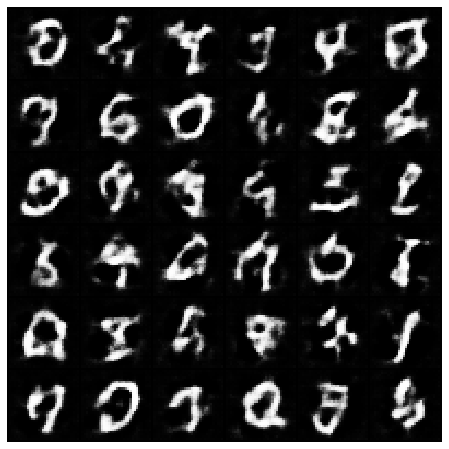

Epoch [2 / 20] G loss: 2.1351358890533447 D loss: 0.3201289176940918


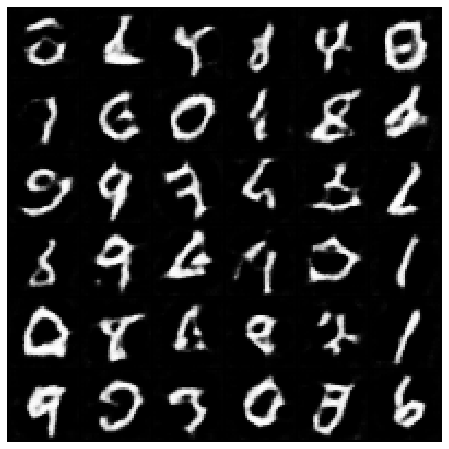

Epoch [3 / 20] G loss: 1.7584508657455444 D loss: 0.31303656101226807


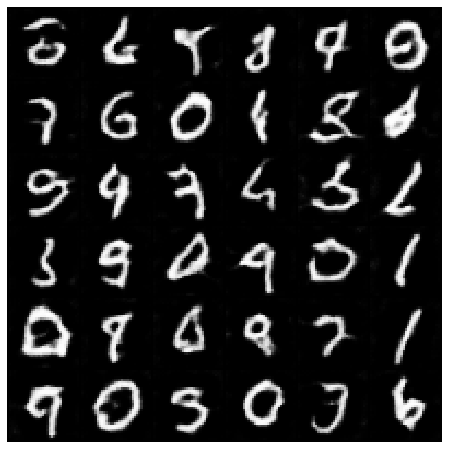

Epoch [4 / 20] G loss: 2.8302485942840576 D loss: 0.5159887075424194


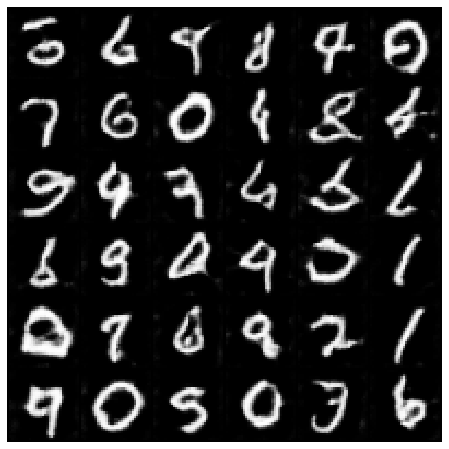

Epoch [5 / 20] G loss: 3.6542251110076904 D loss: 0.1537194550037384


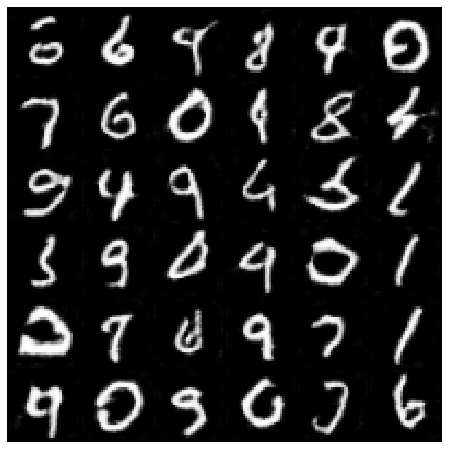

Epoch [6 / 20] G loss: 4.289969444274902 D loss: 0.09383615851402283


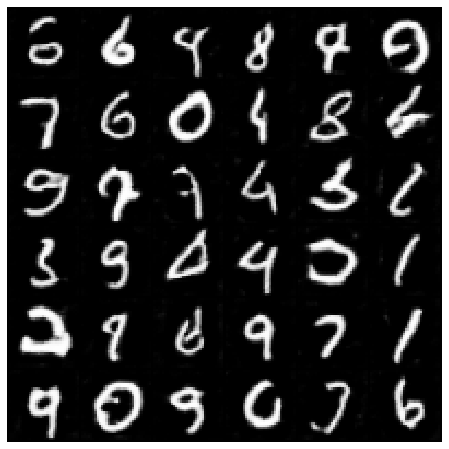

Epoch [7 / 20] G loss: 4.847478866577148 D loss: 0.05365033820271492


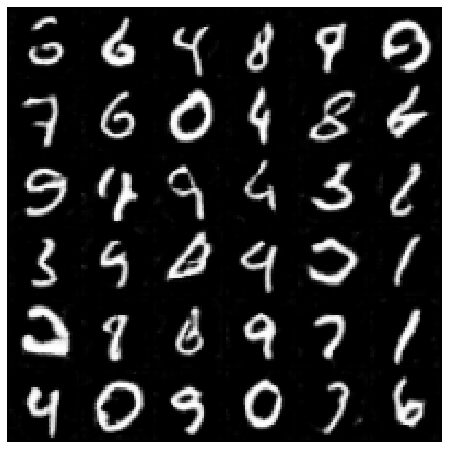

Epoch [8 / 20] G loss: 4.1603827476501465 D loss: 0.1267528235912323


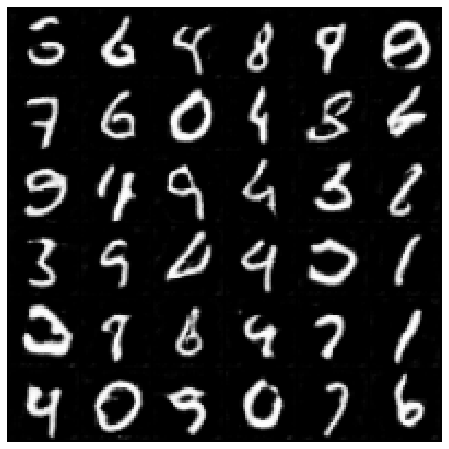

Epoch [9 / 20] G loss: 2.4375905990600586 D loss: 0.41730615496635437


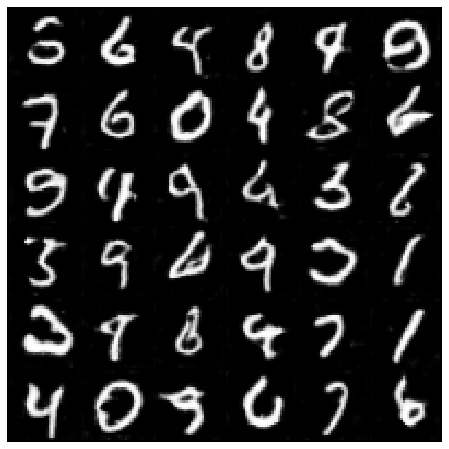

Epoch [10 / 20] G loss: 5.981222629547119 D loss: 0.01871982403099537


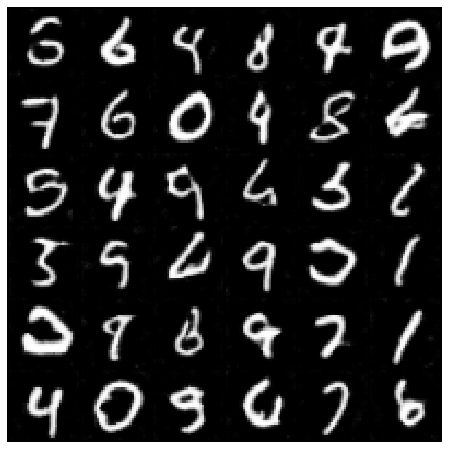

Epoch [11 / 20] G loss: 1.983305811882019 D loss: 0.4897761344909668


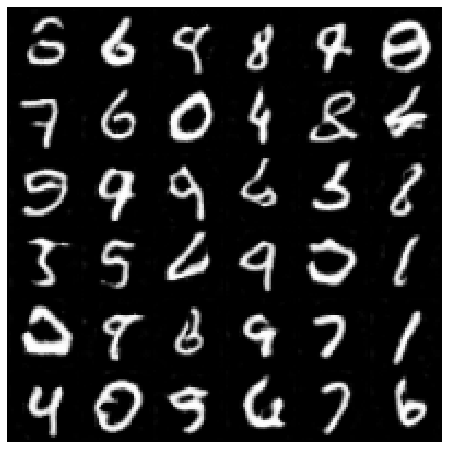

Epoch [12 / 20] G loss: 4.835668087005615 D loss: 0.031423814594745636


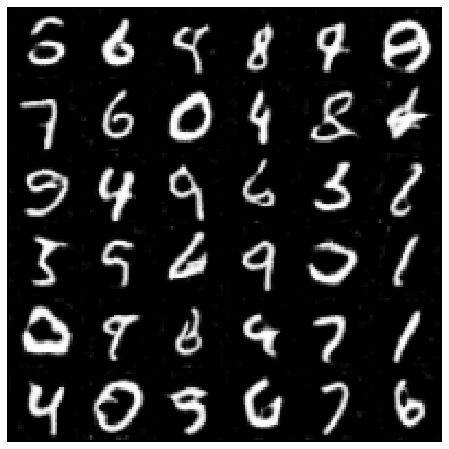

Epoch [13 / 20] G loss: 6.800684452056885 D loss: 0.008980123326182365


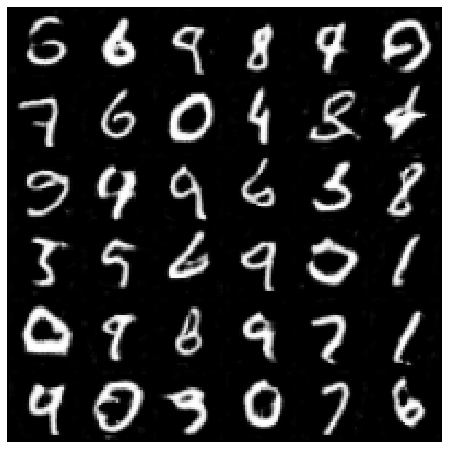

Epoch [14 / 20] G loss: 3.2284629344940186 D loss: 0.2947048544883728


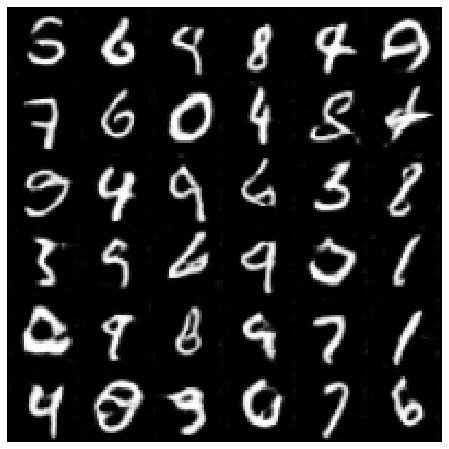

Epoch [15 / 20] G loss: 6.018834590911865 D loss: 0.0116955004632473


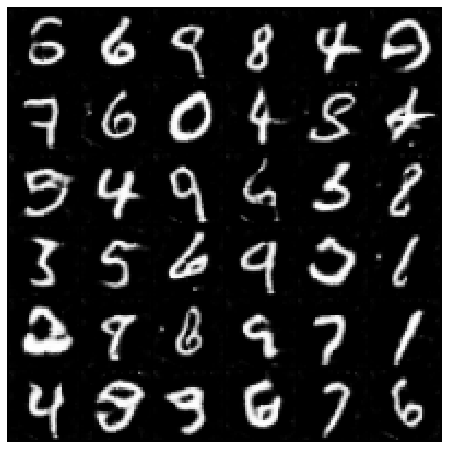

Epoch [16 / 20] G loss: 6.9757537841796875 D loss: 0.007955275475978851


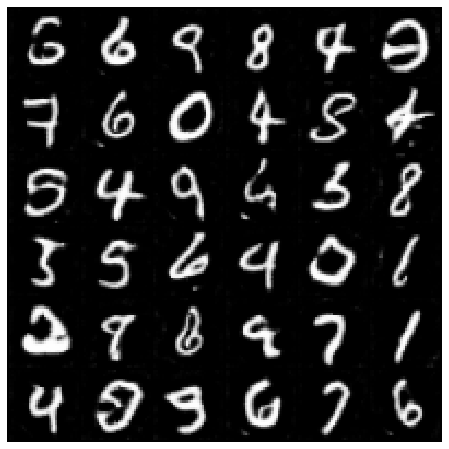

Epoch [17 / 20] G loss: 7.12080192565918 D loss: 1.3243770599365234


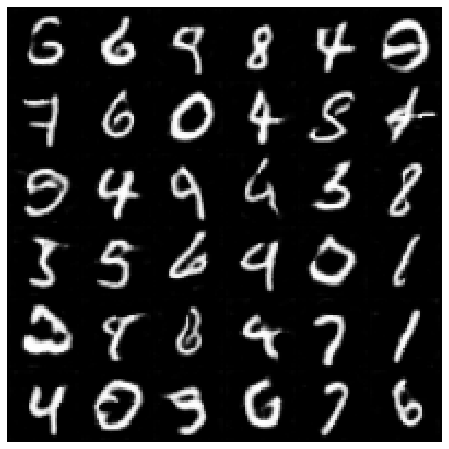

Epoch [18 / 20] G loss: 5.97283935546875 D loss: 0.012362349778413773


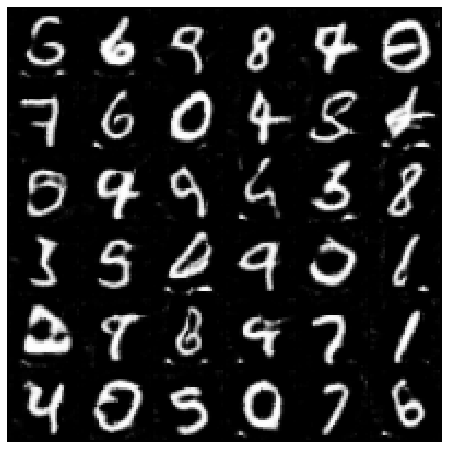

Epoch [19 / 20] G loss: 3.249816656112671 D loss: 1.678726315498352


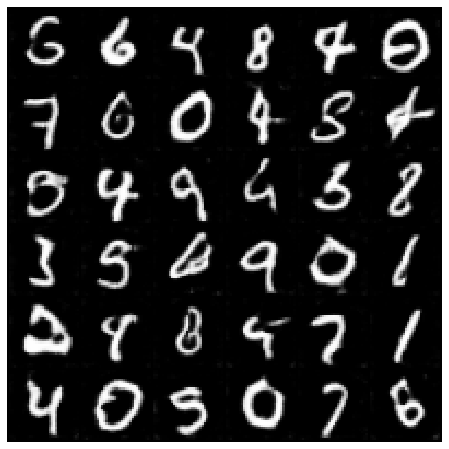

Epoch [20 / 20] G loss: 6.192263126373291 D loss: 0.006114341784268618


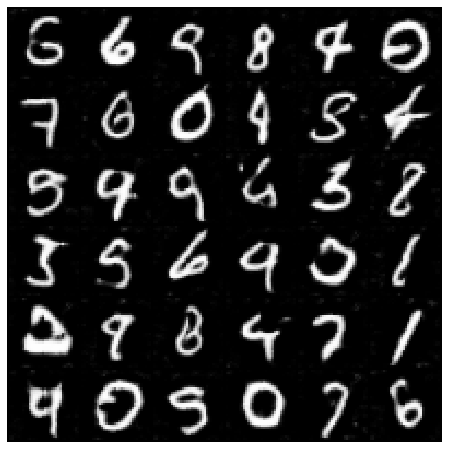

Avg per epoch time: 29.18 sec, total 20 epochs time: 10.00 min
Training finished!
...saving training results


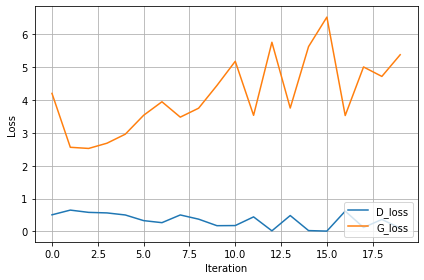

In [17]:
progress = {}
progress['D_losses'] = []
progress['G_losses'] = []
progress['per_epoch_times'] = []
progress['total_time'] = []
num_iter = 0

# start training loop
print('Training ...')
start_time = time.time()
for epoch in np.arange(num_epochs):
    
    D_losses = []
    G_losses = []
    
    epoch_start_time = time.time()
    for real, _ in data_loader:
        real = real.to(device)
        
        #######################################################################################################
        # TODO 5b: Fill code for training loop
        #######################################################################################################
        
        # generate random latent vector z and real and fake labels 
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        real_label = torch.full((batch_size,), 1).to(device)
        fake_label = torch.full((batch_size,), 0).to(device)
    
        # TODO 
        
        # generate fakes    
        fakes = G(z)

        # TODO 
        
        # evaluate fakes
        
        D_fake_loss = criterion(D(fakes.detach()).view(-1), fake_label)
        
        # TODO 

        # evaluate real minibatch
        D_real_loss = criterion(D(real).view(-1), real_label)
         
        # TODO
        
        # accumulate discriminator loss from the information about the real and fake images it just saw
        D_train_loss = D_fake_loss + D_real_loss

        # train discriminator D step
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()    
        
        # train generator to output an image that is classified as real              
        G_train_loss = criterion(D(fakes).view(-1), real_label)
        
        # train generator G step
        G.zero_grad()
        G_train_loss.backward()
        G_optimizer.step()              

        D_losses.append(D_train_loss.data.item())
        G_losses.append(G_train_loss.data.item())

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_time = epoch_end_time - epoch_start_time
    
    print('Epoch [{} / {}] G loss: {} D loss: {}'.format(epoch + 1, num_epochs, G_train_loss, D_train_loss))

    show_result( epoch, save=True, path=result_dir + '/Random/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=False )
    show_result( epoch, save=True, show=True, path=result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, epoch), useFixed=True )
    progress['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    progress['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    progress['per_epoch_times'].append(per_epoch_time)

end_time = time.time()
total_time = end_time - start_time
progress['total_time'].append(total_time)

print('Avg per epoch time: {:.2f} sec, total {:d} epochs time: {:.2f} min'.format(torch.mean(torch.FloatTensor(progress['per_epoch_times'])), num_epochs, total_time / 60))
print('Training finished!')
print('...saving training results')

torch.save(G.state_dict(), result_dir + '/generator_network.pkl')
torch.save(D.state_dict(), result_dir + '/discriminator_network.pkl')
with open(result_dir + '/progress.pkl', 'wb') as f:
    pickle.dump(progress, f)

# plot the loss curves    
plot_losses(progress, save=True, path=result_dir + '/{}_DCGAN_progress.png'.format(dset_name))

# Visualize the training progress as an animated GIF
images = []
for e in range(num_epochs):
    img_name = result_dir + '/Fixed/{}_DCGAN_{}.png'.format(dset_name, e)
    images.append(imageio.imread(img_name))
imageio.mimsave(result_dir + '/DCGAN_generation_animation.gif', images, fps=5)

### Display the animated generation GIF

% edit path to GIF %
<img src='./myDataset_DCGAN/DCGAN_generation_animation.gif' width="512">

### 6) Explore the latent space of the generator (5 points)
We now want to explore the expressiveness of the Generator. Intuitively, a small change in values of the latent vector $z$ should result in a small change in the output image, and a linear interpolation between two latent vectors $z_1$ and $z_2$ should yield a reasonably smooth transition from one valid output image to another. Implement a function that creates a grid of latent vectors, where each row is an interpolation from the leftmost to the rightmost latent vector, with $n$ interpolation steps.

The expected output of this function should look like this (or better): 

<img src="img/latent_space_morph_MNIST.PNG" width="900">


<img src="img/latent_space_morph_FashionMNIST.png" width="900">

In [18]:
generator_path = './myDataset_DCGAN/generator_network.pkl'
G = Generator().to(device)
G = nn.DataParallel(G, device_ids=[g for g in gpu_id])
G.load_state_dict(torch.load(generator_path))
G.eval()
G.to(device)

DataParallel(
  (module): Generator(
    (generator): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): Tanh()
    )
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


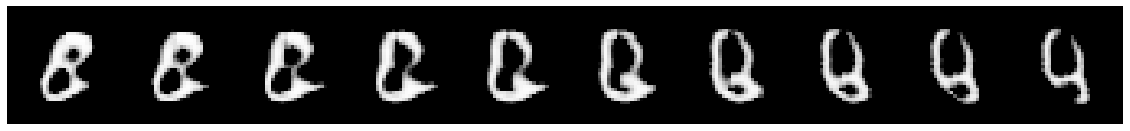

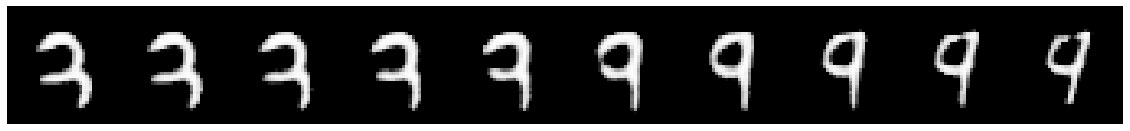

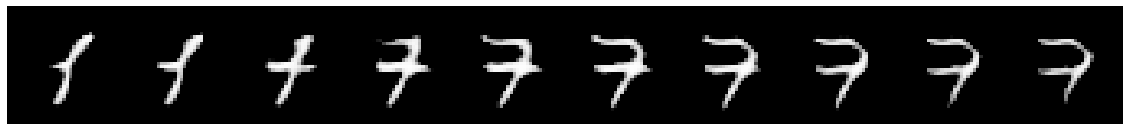

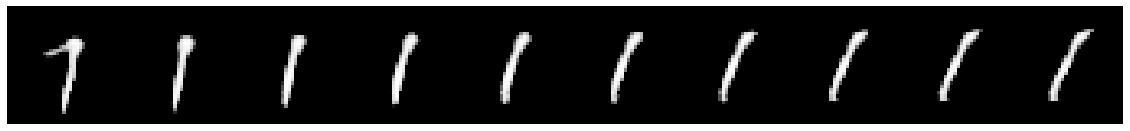

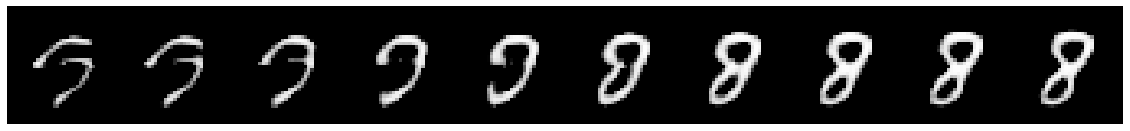

In [20]:
def generate_latent_interpolation(rows=5, interp_steps=10):
     with torch.no_grad():
        #######################################################################################################
        # TODO 6: for each row, create interpolation between leftmost and rightmost output image
        #######################################################################################################
        #leftmot
        for row in range(rows):
            z_left = torch.randn(1,nz,1,1)
            z_s = z_left
            # rightmost
            z_right = torch.randn(1,nz,1,1)
            difference = (z_right - z_left)/(interp_steps-1)
            for i in range(1, interp_steps-1):
                z = difference * i + z_left
                z_s = torch.cat((z_s, z), 0)
            z = torch.cat((z_s, z_right), 0).to(device)
            fakes = G(z).cpu()


                # TODO 

            grid_images = fakes.data   

            fig, ax = plt.subplots(figsize=(20, 10))
            grid = utils.make_grid(grid_images, interp_steps)
            #grid = 1-grid
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            ax.axis('off')

generate_latent_interpolation()        